In [44]:
import geopandas as gpd
import requests
import pickle
from vt2geojson.tools import vt_bytes_to_geojson
import matplotlib.pyplot as plt

from exp_utils import wgp_functions

plt.style.use('dark_background')

In [28]:
def agora_tile_to_dict(wind_dist,z,x,y):
    """
    Function that scrapes the agroa-windflächenrechner tileserver for one vectortile.
    
    Prameters
    ----------
    wind_dist = str, can be '400', '600', '800', '1000'
        Distance to settlement setting
    x,y,z = str
        Parameters of vectortile where:
        x = horizontal extent, y = vertical extent, z = zoom-level 
        
    Returns
    -------
    dict 
        Dictinary entry with x and y parameter plus the GeoJSON information on the vectortile-
    """
    
    url = "https://wfr.agora-energiewende.de/potential_area_mvt/{}/{}/{}/?setup__wind_distance={}".format(z,x,y,wind_dist)
    
    print(f'Downloading tile {x} / {y}')
    r = requests.get(url)
    
    try:
        assert r.status_code == 200, r.content
        
    except AssertionError:
        print(f'    Tile {x} / {y} not available')
    
    vt_content = r.content
    
    # Transformation of binary vectortiles into text-based GeoJson
    features = vt_bytes_to_geojson(vt_content, x, y, z)
    
    return {"x": x, "y": y, 'features': features}


def store_dict(file, dictionary):
    """
    Pickle dump a dictionary
    """
    with open(file, 'wb') as f:
        pickle.dump(dictionary, f)

        
def open_dict(file):
    """
    Opens pickle dump
    """
    with open(file, 'rb') as f:
        dta_import = pickle.load(f)
    return dta_import

## Vectortile scraping: 

Information on the x and y extent under different zoom levels z can be best found here: 
https://developers.google.com/maps/documentation/javascript/examples/maptype-overlay</br>
</br>
The vectortiles are scraped for two zoom levels: 5 and 11. The precision of the polygons changes with the zoom level. 
Zoom level 5 (coarse) is optimal for quick plotting, zoom level 11 (fine) requests the data on the highest resolution, optimal for calculations.</br>
</br>
Zoom level 5: [xmin: 16, xmax: 17, ymin: 10, ymax: 11] </br>
Zoom level 11: [xmin: 1057, xmax: 1109, ymin: 648, ymax: 718]</br>

 

In [41]:
# Zoom level 5 
x = [16, 17]
y= [10, 11]

data1000_z5 = {"potential_area": [wgp_functions.agora_tile_to_dict(wind_dist=1000, z=5, x=a, y=b) for a in x for b in y]}

#wgp_functions.store_dict('data1000_z5.pckl', data1000_z5)

In [ ]:
# Zoom level 11

x = range(1057,1109)
y = range(648,718)

data1000_z11 = {"potential_area": [wgp_functions.agora_tile_to_dict(wind_dist=1000, z=11, x=a, y=b) for a in x for b in y]}

#wgp_functions.store_dict('data1000_z11.pckl', data1000_z11)

### Tile GeoJSON dcit to gpd.DataFrame:

In [42]:
potential_area_1000_z5 = gpd.GeoDataFrame()

tile_count = len(data1000_z5['potential_area'])

potential_area_1000_z5 = potential_area_1000_z5.append([gpd.GeoDataFrame.from_features(data1000_z5['potential_area'][i]['features']) for i in range(0,tile_count)])

print('Tilecount zoom level 5: ',len(potential_area_1000_z5))
potential_area_1000_z5.head()

Tilecount zoom level 5:  4714


,geometry,id
0,"POLYGON ((10.48645 53.40953, 10.50568 53.40462...",79053
1,"POLYGON ((10.56061 53.40789, 10.54413 53.41444...",79052
2,"POLYGON ((10.57983 53.46353, 10.59357 53.44390...",79051
3,"POLYGON ((10.48370 53.46843, 10.49469 53.45862...",79050
4,"POLYGON ((10.52216 53.47660, 10.52765 53.46843...",79049


### Plot the scraped data

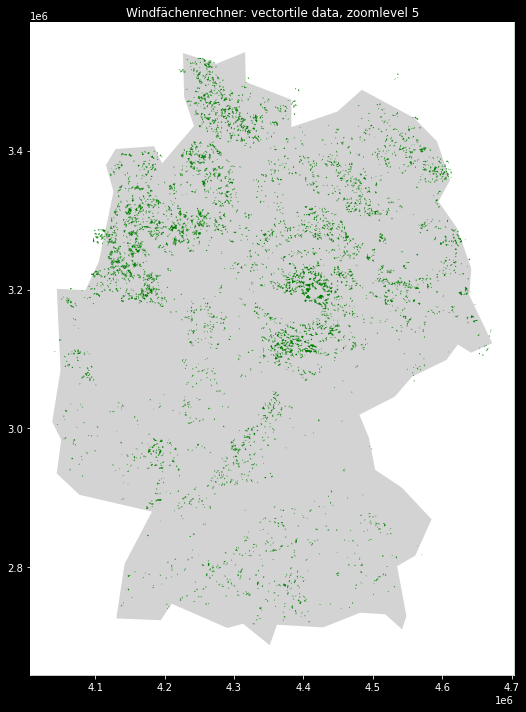

In [46]:
# Adjust CRS
potential_area_1000_z5 = potential_area_1000_z5.set_crs(4326)
potential_area_1000_z5_3035 = potential_area_1000_z5.to_crs(3035)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_3035 = world.to_crs('epsg:3035')
germany = world_3035[world_3035['name'] == 'Germany']


fig, ax = plt.subplots(figsize=(12,12))

germany.plot(color="lightgrey", ax=ax)
potential_area_1000_z5_3035.plot(color="green", ax=ax, aspect='equal')

ax.set_title('Windfächenrechner: vectortile data, zoomlevel 5');

ax.set_aspect('equal')
ax.set_facecolor('white')